In [54]:
!pip install pmdarima

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

# Bước 1: Đọc dữ liệu
file_path = '/content/ETH-USD.csv'
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Hiển thị thông tin cơ bản
print(data.head())
print(data.info())

# Chọn cột 'Close' để phân tích
data = data['Close']




                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-03-01  136.836243  138.995270  136.434784  136.443619  136.443619   
2019-03-02  136.350082  137.184799  132.436386  134.206955  134.206955   
2019-03-03  134.786118  135.849289  131.328857  132.249420  132.249420   
2019-03-04  132.157883  132.729141  125.402702  127.774124  127.774124   
2019-03-05  127.792953  138.229980  126.735298  137.822388  137.822388   

                Volume  
Date                    
2019-03-01  3756124824  
2019-03-02  3747176425  
2019-03-03  3454374053  
2019-03-04  4008171341  
2019-03-05  4764849990  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1920 non-null   float64
 1   High       1920 non-null   float64
 2   Low        1920 n

In [56]:
# Bước 2: Kiểm tra tính dừng
# Kiểm tra ADF
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

print("\nADF Test for Original Series:")
adf_test(data)








ADF Test for Original Series:
ADF Statistic: -1.128206
p-value: 0.703694



ADF Test after Differencing:
ADF Statistic: -10.859473
p-value: 0.000000


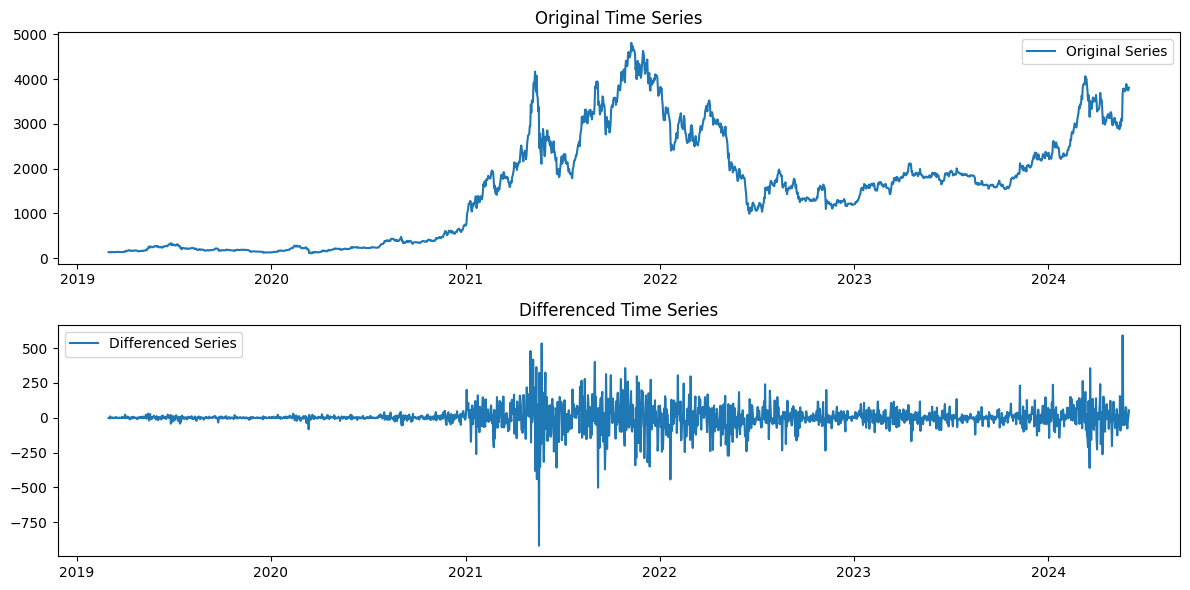

In [57]:
# Bước 3: Làm cho chuỗi có tính dừng (nếu cần)
# Kiểm tra và áp dụng differencing
diff_data = data
if adfuller(data)[1] > 0.05:
    diff_data = data.diff().dropna()
    print("\nADF Test after Differencing:")
    adf_test(diff_data)

# Vẽ biểu đồ chuỗi ban đầu và sau khi differencing
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(data, label='Original Series')
plt.legend(loc='best')
plt.title('Original Time Series')
plt.subplot(212)
if 'diff_data' in locals():
    plt.plot(diff_data, label='Differenced Series')
    plt.legend(loc='best')
    plt.title('Differenced Time Series')
plt.tight_layout()
plt.show()

**Chia tập dữ liệu 7:3**

In [58]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(diff_data) * 0.7)
train, test = diff_data[:train_size], diff_data[train_size:]


In [59]:
# Bước 5: Tìm các thông số ARIMA
# Sử dụng auto_arima để tìm p, d, q tốt nhất
auto_model = auto_arima(train, seasonal=False, trace=True)
print(auto_model.summary())

# Lấy thông số từ auto_arima
p, d, q = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15906.712, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15907.891, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15903.158, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15903.427, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=15904.836, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15904.984, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=15905.465, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15904.954, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 2.474 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1343
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -7949.579
Date:                Tue, 18 Jun 2024   AIC                          15903.158
Time:                       

In [60]:
# Bước 6: Huấn luyện mô hình ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [61]:
# Bước 7: Dự đoán trên tập kiểm tra
forecast_test = model_fit.forecast(steps=len(test))
test_forecast = pd.Series(forecast_test, index=test.index)

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [63]:
# Bước 8: Đánh giá mô hình
# MSE
mse = mean_squared_error(test, test_forecast)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(test, test_forecast)

# MAPE
mape = np.mean(np.abs((test - test_forecast) / test)) * 100

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 4839.62287611362
Root Mean Squared Error (RMSE): 69.56739808353925
Mean Absolute Error (MAE): 43.13871033499218
Mean Absolute Percentage Error (MAPE): 105.41%


In [64]:
# Bước 9: Dự đoán cho 30, 60, và 90 ngày tương lai
future_steps = [30, 60, 90]
future_forecasts = {}
for steps in future_steps:
    future_forecasts[steps] = model_fit.forecast(steps=steps)

# Tạo chỉ số thời gian cho dự đoán tương lai
last_date = diff_data.index[-1]
future_dates = {
    30: pd.date_range(last_date, periods=31)[1:],  # Bỏ ngày đầu tiên vì nó là ngày cuối cùng của dữ liệu
    60: pd.date_range(last_date, periods=61)[1:],
    90: pd.date_range(last_date, periods=91)[1:]
}

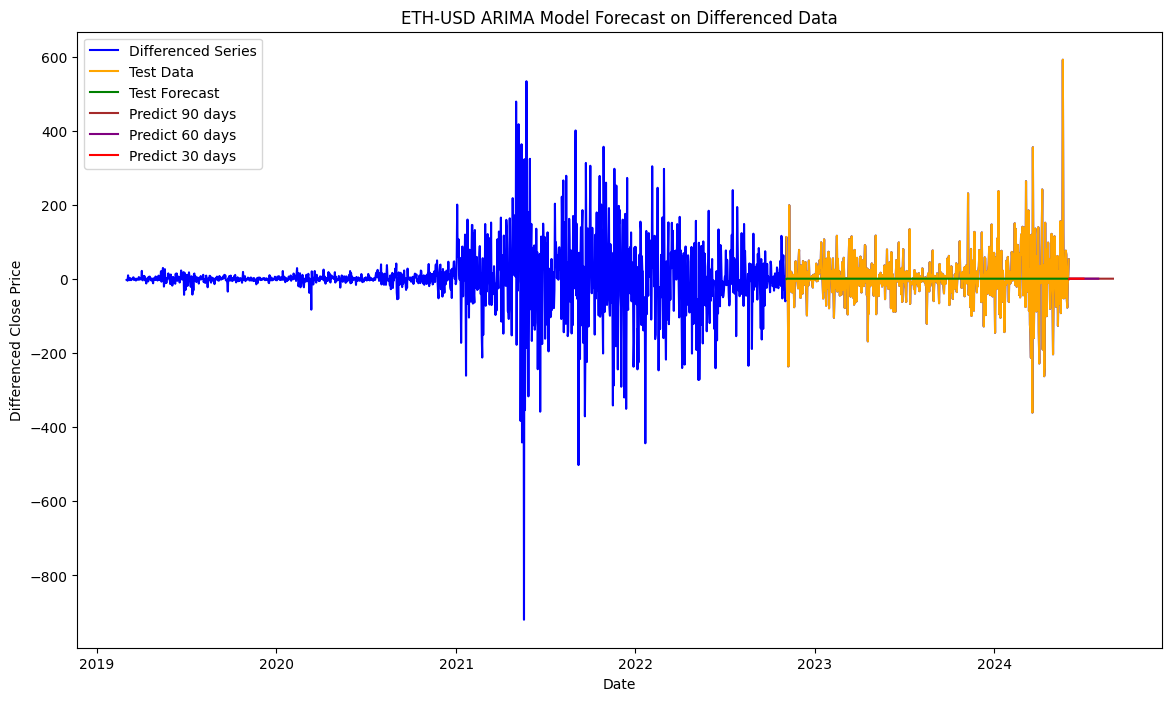

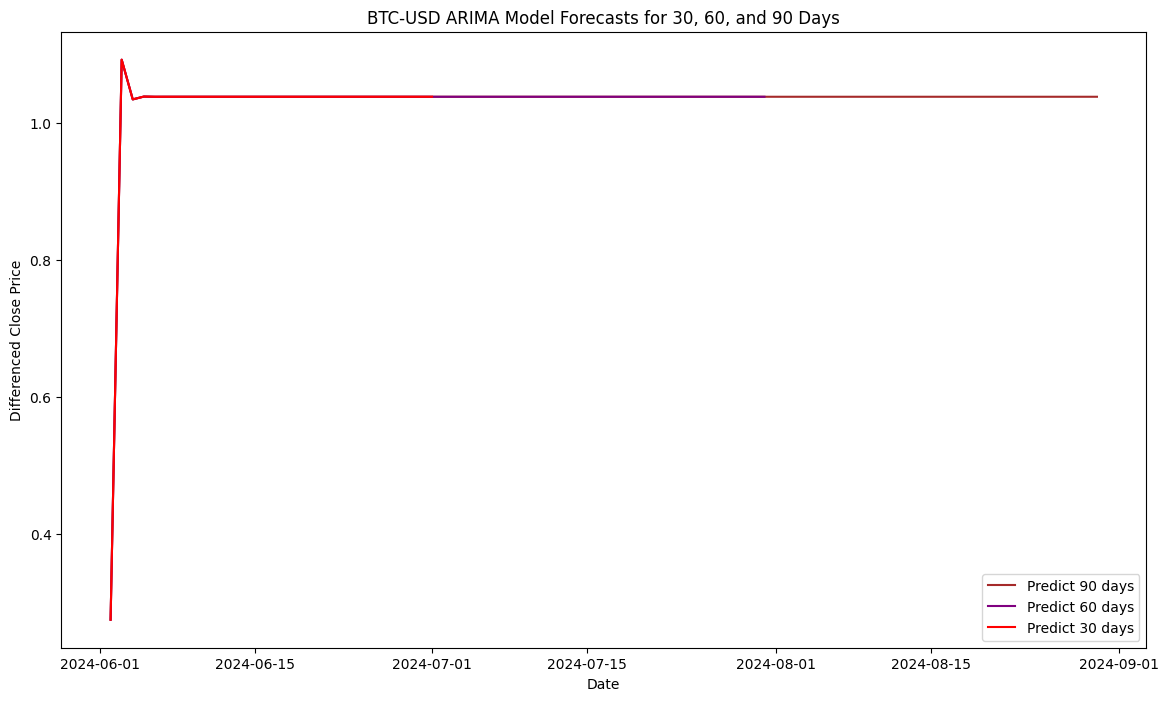

In [65]:

# Bước 10: Vẽ biểu đồ kết hợp

plt.figure(figsize=(14, 8))

# Biểu đồ dữ liệu đã differenced (dữ liệu có tính dừng)
plt.plot(diff_data, label='Differenced Series', color='blue')

# Biểu đồ dữ liệu kiểm tra
plt.plot(test.index, test, label='Test Data', color='orange')

# Biểu đồ dự đoán trên tập kiểm tra
plt.plot(test.index, test_forecast, label='Test Forecast', color='green')

# Dự đoán cho tương lai
# Thứ tự vẽ lần lượt từ 90 ngày, 60 ngày đến 30 ngày để đảm bảo hiển thị rõ ràng
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('ETH-USD ARIMA Model Forecast on Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

# Chỉ hiển thị dự đoán cho 30, 60, và 90 ngày
plt.figure(figsize=(14, 8))

# Vẽ từ 90 ngày trước, sau đó là 60 ngày và cuối cùng là 30 ngày
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecasts for 30, 60, and 90 Days')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

Chia dữ liệu 8:2

In [66]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 80:20
train_size = int(len(diff_data) * 0.8)
train, test = diff_data[:train_size], diff_data[train_size:]

In [67]:
# Bước 5: Tìm các thông số ARIMA
# Sử dụng auto_arima để tìm p, d, q tốt nhất
auto_model = auto_arima(train, seasonal=False, trace=True)
print(auto_model.summary())

# Lấy thông số từ auto_arima
p, d, q = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=18046.407, Time=2.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18048.212, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=18042.828, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18043.076, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=18044.592, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18044.701, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18045.315, Time=1.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18044.551, Time=0.25 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 5.788 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1535
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -9019.414
Date:                Tue, 18 Jun 2024   AIC                          18042.828
Time:                       

In [68]:
# Bước 6: Huấn luyện mô hình ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [69]:
# Bước 7: Dự đoán và đánh giá mô hình
# Dự đoán trên tập kiểm tra
forecast = model_fit.forecast(steps=len(test))
test_forecast = pd.Series(forecast, index=test.index)


In [70]:
# Bước 8: Đánh giá mô hình
# MSE
mse = mean_squared_error(test, test_forecast)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(test, test_forecast)

# MAPE
mape = np.mean(np.abs((test - test_forecast) / test)) * 100

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Squared Error (MSE): 5901.107205256249
Root Mean Squared Error (RMSE): 76.8186644329114
Mean Absolute Error (MAE): 46.91405646649878
Mean Absolute Percentage Error (MAPE): 101.52%


In [71]:
# Bước 9: Dự đoán cho 30, 60, và 90 ngày tương lai
future_steps = [30, 60, 90]
future_forecasts = {}
for steps in future_steps:
    future_forecasts[steps] = model_fit.forecast(steps=steps)

# Tạo chỉ số thời gian cho dự đoán tương lai
last_date = diff_data.index[-1]
future_dates = {
    30: pd.date_range(last_date, periods=31)[1:],  # Bỏ ngày đầu tiên vì nó là ngày cuối cùng của dữ liệu
    60: pd.date_range(last_date, periods=61)[1:],
    90: pd.date_range(last_date, periods=91)[1:]
}

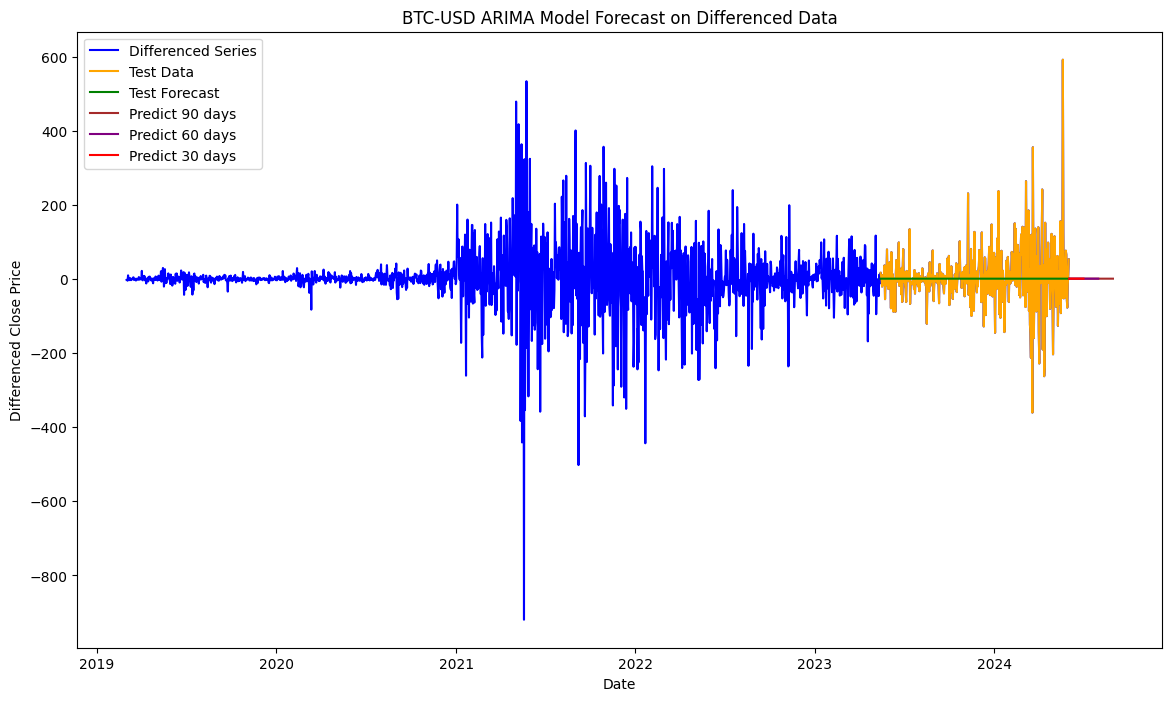

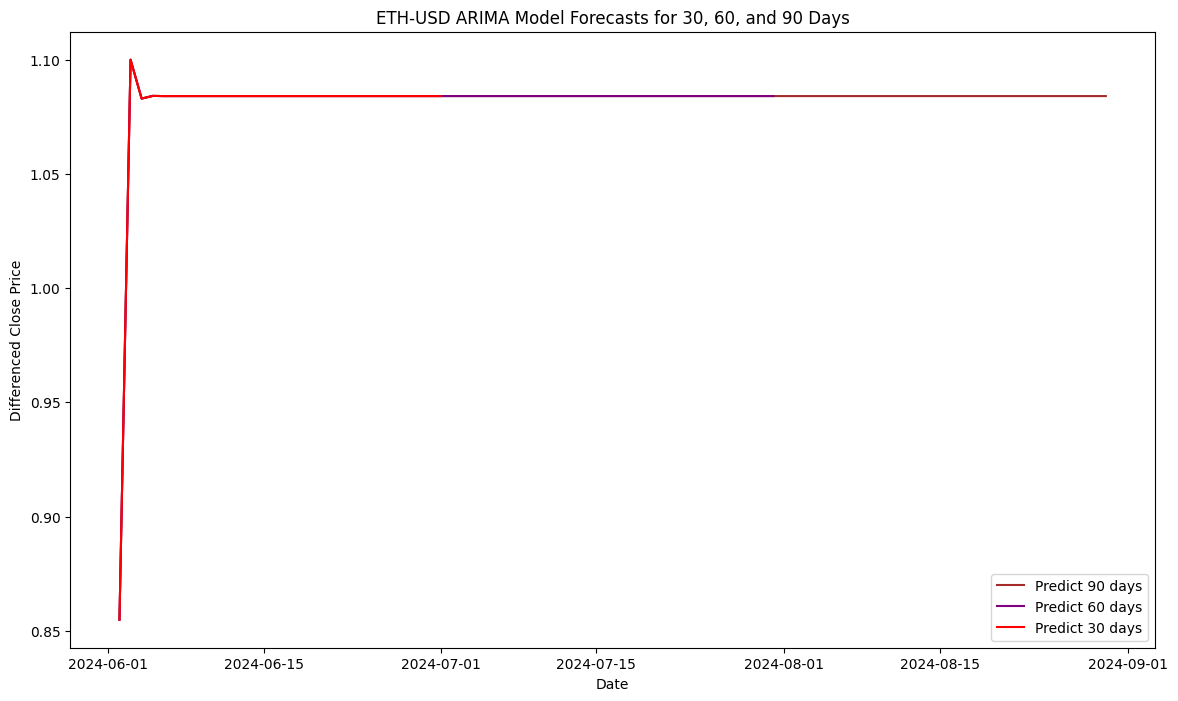

In [72]:

# Bước 10: Vẽ biểu đồ kết hợp

plt.figure(figsize=(14, 8))

# Biểu đồ dữ liệu đã differenced (dữ liệu có tính dừng)
plt.plot(diff_data, label='Differenced Series', color='blue')

# Biểu đồ dữ liệu kiểm tra
plt.plot(test.index, test, label='Test Data', color='orange')

# Biểu đồ dự đoán trên tập kiểm tra
plt.plot(test.index, test_forecast, label='Test Forecast', color='green')

# Dự đoán cho tương lai
# Thứ tự vẽ lần lượt từ 90 ngày, 60 ngày đến 30 ngày để đảm bảo hiển thị rõ ràng
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecast on Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

# Chỉ hiển thị dự đoán cho 30, 60, và 90 ngày
plt.figure(figsize=(14, 8))

# Vẽ từ 90 ngày trước, sau đó là 60 ngày và cuối cùng là 30 ngày
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('ETH-USD ARIMA Model Forecasts for 30, 60, and 90 Days')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

**Chia dữ liệu tỷ lệ 6 : 4**

In [73]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 60:40
train_size = int(len(diff_data) * 0.6)
train, test = diff_data[:train_size], diff_data[train_size:]

In [74]:
# Bước 5: Tìm các thông số ARIMA
# Sử dụng auto_arima để tìm p, d, q tốt nhất
auto_model = auto_arima(train, seasonal=False, trace=True)
print(auto_model.summary())

# Lấy thông số từ auto_arima
p, d, q = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13661.896, Time=3.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13673.954, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13670.102, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13670.170, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13673.409, Time=1.34 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13674.102, Time=0.41 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=13670.794, Time=3.78 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=13649.430, Time=4.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=13671.012, Time=1.35 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=13661.395, Time=2.52 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=13651.394, Time=4.73 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=13662.319, Time=1.99 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=13657.883, Time=5.65 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=13650.858, Time=5.34 sec

Best model:  ARIMA

In [75]:
# Bước 6: Huấn luyện mô hình ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [76]:
# Bước 7: Dự đoán trên tập kiểm tra
forecast_test = model_fit.forecast(steps=len(test))
test_forecast = pd.Series(forecast_test, index=test.index)

In [77]:
# Bước 8: Đánh giá mô hình
# MSE
mse = mean_squared_error(test, test_forecast)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(test, test_forecast)

# MAPE
mape = np.mean(np.abs((test - test_forecast) / test)) * 100

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 5257.502052765912
Root Mean Squared Error (RMSE): 72.50863433251182
Mean Absolute Error (MAE): 46.968313760822944
Mean Absolute Percentage Error (MAPE): 133.07%


In [78]:
# Bước 9: Dự đoán cho 30, 60, và 90 ngày tương lai
future_steps = [30, 60, 90]
future_forecasts = {}
for steps in future_steps:
    future_forecasts[steps] = model_fit.forecast(steps=steps)

# Tạo chỉ số thời gian cho dự đoán tương lai
last_date = diff_data.index[-1]
future_dates = {
    30: pd.date_range(last_date, periods=31)[1:],  # Bỏ ngày đầu tiên vì nó là ngày cuối cùng của dữ liệu
    60: pd.date_range(last_date, periods=61)[1:],
    90: pd.date_range(last_date, periods=91)[1:]
}

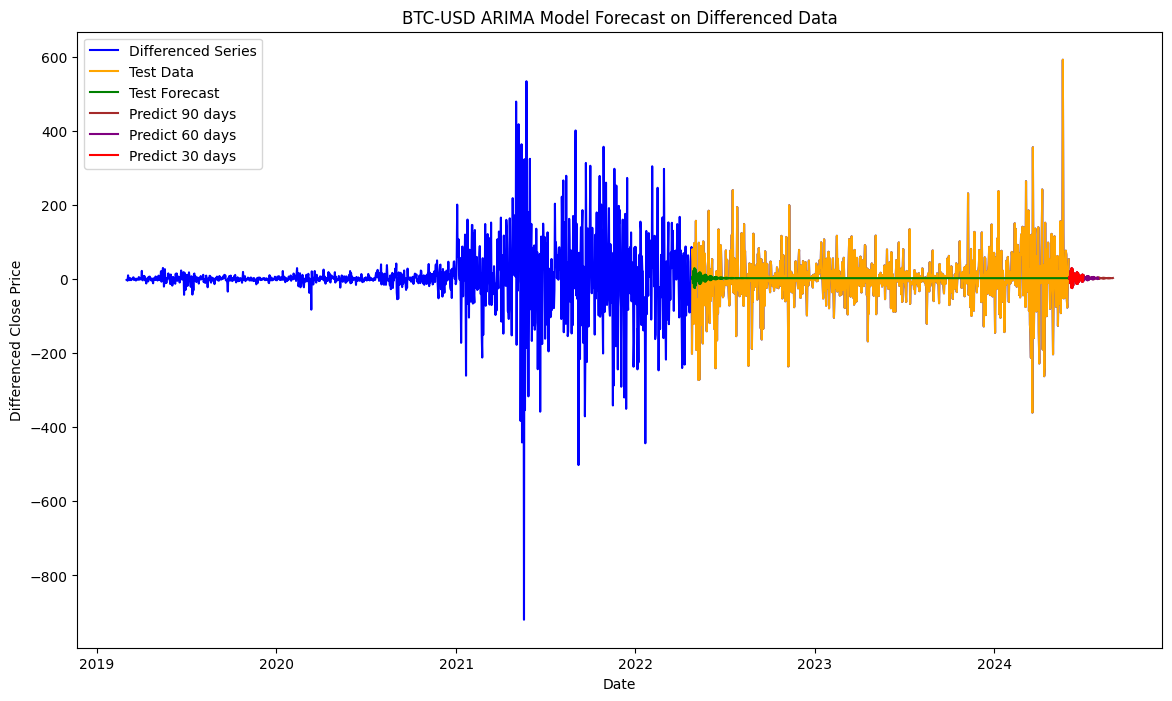

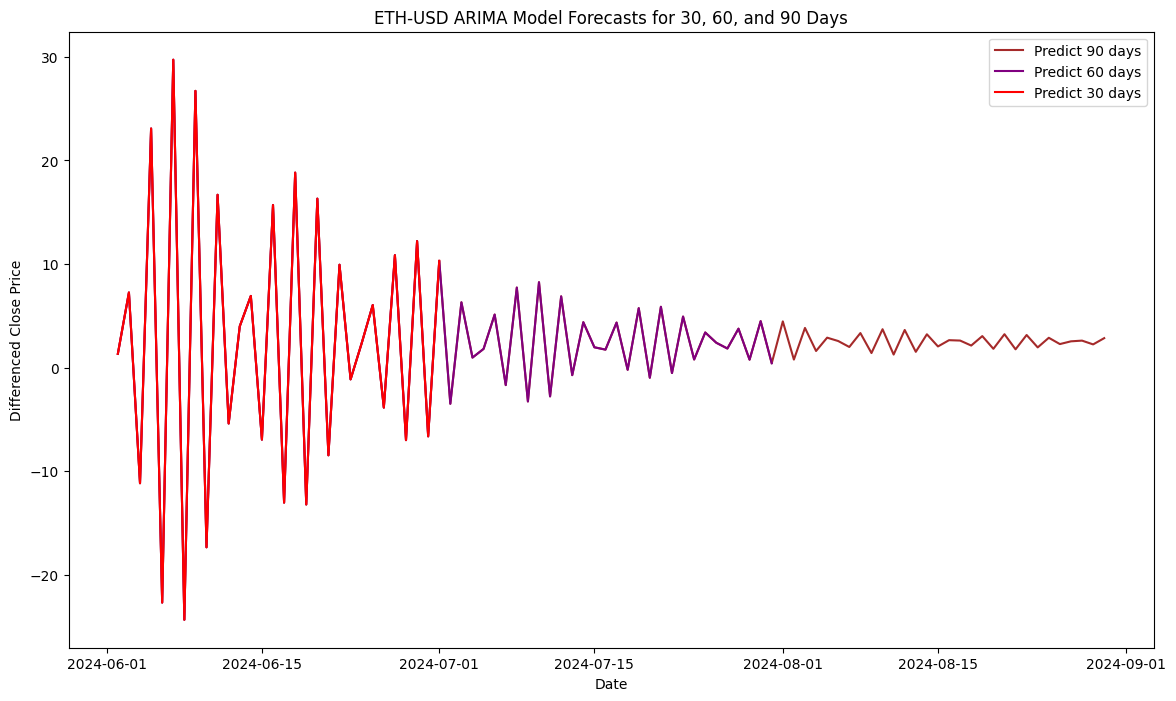

In [79]:

# Bước 10: Vẽ biểu đồ kết hợp

plt.figure(figsize=(14, 8))

# Biểu đồ dữ liệu đã differenced (dữ liệu có tính dừng)
plt.plot(diff_data, label='Differenced Series', color='blue')

# Biểu đồ dữ liệu kiểm tra
plt.plot(test.index, test, label='Test Data', color='orange')

# Biểu đồ dự đoán trên tập kiểm tra
plt.plot(test.index, test_forecast, label='Test Forecast', color='green')

# Dự đoán cho tương lai
# Thứ tự vẽ lần lượt từ 90 ngày, 60 ngày đến 30 ngày để đảm bảo hiển thị rõ ràng
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecast on Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

# Chỉ hiển thị dự đoán cho 30, 60, và 90 ngày
plt.figure(figsize=(14, 8))

# Vẽ từ 90 ngày trước, sau đó là 60 ngày và cuối cùng là 30 ngày
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('ETH-USD ARIMA Model Forecasts for 30, 60, and 90 Days')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()